In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
# Load the dataset from the Excel file
data = pd.read_excel('/bin/Dataset (1).xlsx')
data.head()

,Protocol,Info,Length,Delta,Type
0,HCI_EVT,Rcvd Link Key Request,9,0.010473,au_rand_flooding
1,HCI_CMD,Sent Link Key Request Negative Reply,10,0.010473,au_rand_flooding
2,HCI_EVT,Rcvd Link Key Request,9,0.017913,au_rand_flooding
3,HCI_EVT,Rcvd Command Complete (Link Key Request Negati...,13,0.002642,au_rand_flooding
4,HCI_CMD,Sent Link Key Request Negative Reply,10,0.002882,au_rand_flooding


In [ ]:
# Count of each type of event
event_counts = data['Type'].value_counts()
print(event_counts)

normal                             6269
au_rand_flooding                    655
truncated_sco_link_request          340
duplicated_iocap                    299
truncated_lmp_accepted              274
invalid_feature_page_execution      250
feature_response_flooding           216
invalid_timing_accuracy             211
lmp_overflow_dm1                    159
lmp_auto_rate_overflow              151
duplicated_encapsulated_payload     111
invalid_setup_complete               67
Name: Type, dtype: int64


In [ ]:
pip install matplotlib seaborn


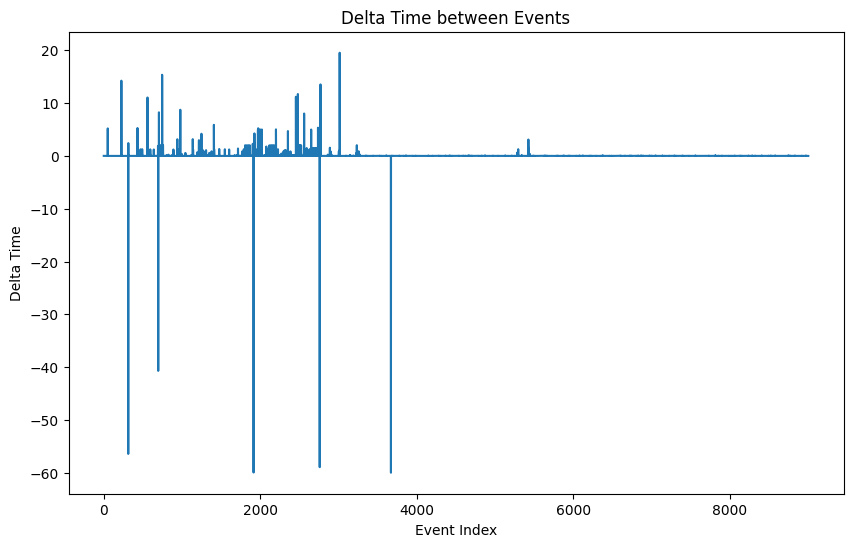

In [ ]:
#temporal analysis
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Delta' is your column of interest
plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x=data.index, y='Delta')
plt.title('Delta Time between Events')
plt.xlabel('Event Index')
plt.ylabel('Delta Time')
plt.show()


Outliers:
             Protocol                                  Info  Length  \
51            HCI_EVT                 Rcvd Link Key Request       9   
225   HCI H4 Broadcom                               LM Sent      64   
313   HCI H4 Broadcom                               LM Sent      64   
431           HCI_EVT                 Rcvd Link Key Request       9   
559               LMP                           LMP_au_rand      29   
696           HCI_EVT     Rcvd Remote Name Request Complete     258   
705               LMP                      LMP_features_req      21   
746          Baseband                                   FHS      28   
978               LMP                      LMP_features_req      21   
1407  HCI H4 Broadcom                               LM Sent      64   
1914          HCI_EVT                 Rcvd Connect Complete      14   
1925              LMP                      LMP_features_req      21   
1969              LMP                          LMP_accepted      14

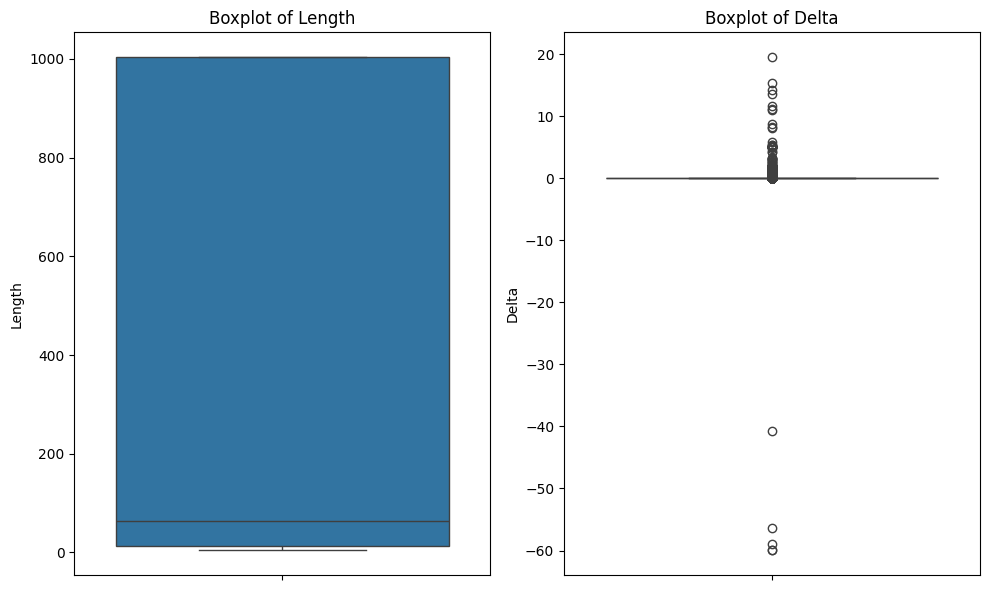

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting numerical columns for outlier detection
numerical_columns = ['Length', 'Delta']

# Detecting outliers using z-score method
from scipy import stats

# Define a threshold for z-score
z_score_threshold = 3

# Function to detect outliers using z-score
def detect_outliers_z_score(data, threshold=3):
    z_scores = stats.zscore(data)
    abs_z_scores = abs(z_scores)
    outlier_indices = abs_z_scores > threshold
    return outlier_indices

# Detect outliers in numerical columns
outlier_indices = detect_outliers_z_score(df[numerical_columns], threshold=z_score_threshold)

# Display rows with outliers
outliers = df[outlier_indices.any(axis=1)]
print("Outliers:")
print(outliers)

# Visualize outliers using boxplots
plt.figure(figsize=(10, 6))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(1, len(numerical_columns), i)
    sns.boxplot(y=df[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()


In [ ]:

# Separate features (X) and target variable (y)
X = data[['Protocol', 'Length', 'Delta']]  # Select relevant features for training
y = data['Type']  # Assuming 'Type' column indicates whether it's an attack or not

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing steps for different types of columns
# One-hot encode the 'Protocol' column
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Protocol'])
    ],
    remainder='passthrough'
)

# Define the pipeline with preprocessing and classifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Train the model
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)



In [ ]:
import pandas as pd
import numpy as np

# Load your dataset into a Pandas DataFrame
df = pd.read_excel('/bin/Dataset (1).xlsx', engine='openpyxl')

# Select only the numeric columns
X = df.select_dtypes(include=['float64', 'int64'])

# Select the target column (assuming it's called 'target')
y = df['Type']

# Split the dataset into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the base models
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

models = [
    ('lr', DecisionTreeClassifier(random_state=42)),
    ('svm', SVC(probability=True, random_state=42)),
    ('dt', LogisticRegression(random_state=42))
]

# Define the meta model
meta_model = LogisticRegression(random_state=42)

# Create the stacking classifier
stacking_classifier = StackingClassifier(
    estimators=models, final_estimator=meta_model, cv=5)

# Fit the stacking classifier to the dataset
stacking_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = stacking_classifier.predict(X_test)

# Print the accuracy score
from sklearn.metrics import accuracy_score

print('Stacking accuracy score:', accuracy_score(y_test, y_pred))

# Function to create the input dataset for the meta-learner
def stacked_dataset(models, X):
    stacked_inputs = np.zeros((X.shape[0], len(models)))
    for i, model in enumerate(models):
        stacked_inputs[:, i] = model.predict_proba(X)[:, 1]
    return stacked_inputs

# Create the input dataset for the meta-learner
X_stacked = stacked_dataset(stacking_classifier.estimators_, X_train)

# Train the meta-learner
meta_model.fit(X_stacked, y_train)

# Make predictions on the test set using the stacking classifier
y_pred_stacked = stacking_classifier.predict(X_test)

# Print the accuracy score for the stacking classifier
print('Stacking classifier accuracy score:', accuracy_score(y_test, y_pred_stacked))

# Make predictions on the test set using the meta-learner
y_pred_meta = meta_model.predict(stacked_dataset(stacking_classifier.estimators_, X_test))

# Print the accuracy score for the meta-learner
print('Meta-learner accuracy score:', accuracy_score(y_test, y_pred_meta))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Stacking accuracy score: 0.7834536368684064
Stacking classifier accuracy score: 0.7834536368684064
Meta-learner accuracy score: 0.6868406440866185
